# Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from utils.carbon import calculate_total_carbon
from utils.cost import calculate_total_cost
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preprocess Data

In [3]:
# INPUTS

TIME_HORIZON = 2050
CSV_FILE_NAME = "2050_merged_simulation_results.csv" 

In [4]:
# Load the data
file_path = f"inputs/{CSV_FILE_NAME}"
df = pd.read_csv(file_path)

In [5]:
# Column labels
SIMULATION_ID = "simulation_id"
WINDOWS_U_FACTOR = 'windows_U_Factor'
GROUND_FLOOR_THERMAL_RESISTANCE = "groundfloor_thermal_resistance"
EXT_WALLS_THERMAL_RESISTANCE = "ext_walls_thermal_resistance"
ROOF_THERMAL_RESISTANCE= "roof_thermal_resistance"
ANNUAL_ENERGY_CONSUMPTION = "annual_energy_consumption"
TOTAL_COST = "total_cost"
TOTAL_CARBON_EMISSION = "total_carbon_emission"
COMFORT_DAYS = "comfort_days"

ELECTRICITY_BUILDING = "Electricity:Building"
ELECTRICITY_FACILITY = "Electricity:Facility"
GAS_CONSUMPTION = "Gas Consumption"
INDOOR_TEMPERATURE = "Zone Mean Air Temperature"

In [6]:


# Date columns
date_columns = [col for col in df.columns if col.startswith(f"{str(TIME_HORIZON)}-")]



In [8]:

# Initialize the dataframe with the inputs
df_inputs = pd.DataFrame()
df_inputs = pd.DataFrame(columns=[SIMULATION_ID, WINDOWS_U_FACTOR, GROUND_FLOOR_THERMAL_RESISTANCE, EXT_WALLS_THERMAL_RESISTANCE, ROOF_THERMAL_RESISTANCE])

# Initialize the dataframe with the outputs
df_outputs = pd.DataFrame()
df_outputs = pd.DataFrame(columns=[SIMULATION_ID, ANNUAL_ENERGY_CONSUMPTION, TOTAL_COST, TOTAL_CARBON_EMISSION, COMFORT_DAYS])

for simulation_id, group in df.groupby('Simulation ID'):

    # Inputs
    df_inputs = pd.concat([df_inputs,
        pd.DataFrame({
            SIMULATION_ID: [int(simulation_id)],
            WINDOWS_U_FACTOR : [group[WINDOWS_U_FACTOR].iloc[0]],
            GROUND_FLOOR_THERMAL_RESISTANCE:[group[GROUND_FLOOR_THERMAL_RESISTANCE].iloc[0]],
            EXT_WALLS_THERMAL_RESISTANCE:[group[EXT_WALLS_THERMAL_RESISTANCE].iloc[0]],
            ROOF_THERMAL_RESISTANCE: [group[ROOF_THERMAL_RESISTANCE].iloc[0]]
        })], ignore_index=True
    )



    # Extract values
    electricity_building = group[group['index'].str.contains(ELECTRICITY_BUILDING)].iloc[0]
    electricity_facility = group[group['index'].str.contains(ELECTRICITY_FACILITY)].iloc[0] 
    gas_consumption = group[group['index'].str.contains(GAS_CONSUMPTION)].iloc[0] 
    indoor_temperature=group[group['index'].str.contains(INDOOR_TEMPERATURE)].iloc[0]


    annual_energy_consumption = (electricity_building[date_columns].sum() + 
                            electricity_facility[date_columns].sum() + 
                            gas_consumption[date_columns].sum())/10**9
    

    window_U_factor= group[WINDOWS_U_FACTOR].iloc[0]
    groundfloor_thermal_resistance=group[GROUND_FLOOR_THERMAL_RESISTANCE].iloc[0]
    ext_walls_thermal_resistance=group[EXT_WALLS_THERMAL_RESISTANCE].iloc[0]
    roof_thermal_resistance=group[ROOF_THERMAL_RESISTANCE].iloc[0]

    total_cost = calculate_total_cost(
        window_U_Factor=window_U_factor, 
        groundfloor_thermal_resistance=groundfloor_thermal_resistance,
        ext_walls_thermal_resistance=ext_walls_thermal_resistance, 
        roof_thermal_resistance=roof_thermal_resistance
        )
    
    comfort_days = min(len([item for item in indoor_temperature[date_columns].values if 18<item<24]),365)
    
    total_carbon_emission = calculate_total_carbon(        
        window_U_Factor=window_U_factor, 
        groundfloor_thermal_resistance=groundfloor_thermal_resistance,
        ext_walls_thermal_resistance=ext_walls_thermal_resistance, 
        roof_thermal_resistance=roof_thermal_resistance
        )
    

    df_outputs = pd.concat([df_outputs,
        pd.DataFrame({
            SIMULATION_ID: [int(simulation_id)],
            ANNUAL_ENERGY_CONSUMPTION : [annual_energy_consumption],
            TOTAL_COST: [total_cost],
            TOTAL_CARBON_EMISSION: [total_carbon_emission],
            COMFORT_DAYS: [comfort_days]
        })], ignore_index=True
    )

/var/folders/76/c14d3r6j5w310ybq_1tgcc0r0000gn/T/ipykernel_35464/1486661244.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_inputs = pd.concat([df_inputs,
/var/folders/76/c14d3r6j5w310ybq_1tgcc0r0000gn/T/ipykernel_35464/1486661244.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_outputs = pd.concat([df_outputs,


In [9]:
df_inputs


,simulation_id,windows_U_Factor,groundfloor_thermal_resistance,ext_walls_thermal_resistance,roof_thermal_resistance
0,1,2.90,0.41,0.45,0.48
1,2,2.90,0.41,4.00,0.48
2,3,2.90,0.41,4.01,0.48
3,4,2.90,0.41,6.67,0.48
4,5,2.90,0.41,6.68,0.48
...,...,...,...,...,...
620,621,0.81,5.57,0.45,8.34
621,622,0.81,5.57,4.00,8.34
622,623,0.81,5.57,4.01,8.34
623,624,0.81,5.57,6.67,8.34


In [10]:
df_outputs

,simulation_id,annual_energy_consumption,total_cost,total_carbon_emission,comfort_days
0,1,4075.920705,0,0,247
1,2,3904.460084,182,9.36,260
2,3,3890.866532,179,4.83,259
3,4,3880.847108,200,17.16,261
4,5,3877.059993,222,8.5,260
...,...,...,...,...,...
620,621,3987.337647,869,137.68,266
621,622,3817.044451,1051,147.04,278
622,623,3806.772476,1048,142.51,276
623,624,3786.355399,1069,154.84,278


# Load and Preprocess data


In [ ]:
X_data = df_inputs[[WINDOWS_U_FACTOR, GROUND_FLOOR_THERMAL_RESISTANCE, EXT_WALLS_THERMAL_RESISTANCE, ROOF_THERMAL_RESISTANCE]].values
Y_data = df_outputs[[ANNUAL_ENERGY_CONSUMPTION, TOTAL_COST, TOTAL_CARBON_EMISSION, COMFORT_DAYS]].values
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
# Normalize the data 
X_data_normalized = scaler_X.fit_transform(X_data)
Y_data_normalized = scaler_Y.fit_transform(Y_data)

# Y_ORIGINAL = scaler_Y.inverse_transform(Y_data_normalized)


# Split the dataset into training, testing and validation sets
# Split data into train, validation, and test sets
# Training Set: 70% of the original data.
# Validation Set: 15% of the original data (from the temporary set).
# Test Set: 15% of the original data (from the temporary set).

train_inputs, temp_inputs, train_outputs, temp_outputs = train_test_split(
    X_data_normalized, Y_data_normalized, test_size=0.3, random_state=42
)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(
    temp_inputs, temp_outputs, test_size=0.5, random_state=42
)

# Convert to torch tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
train_outputs = torch.tensor(train_outputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
val_outputs = torch.tensor(val_outputs, dtype=torch.float32)
test_inputs = torch.tensor(test_inputs, dtype=torch.float32)
test_outputs = torch.tensor(test_outputs, dtype=torch.float32)

In [24]:
test_outputs

tensor([[-0.4868, -1.0781, -1.2983, -0.2079],
        [-0.3460, -0.6619, -0.4573, -0.2079],
        [ 2.4503, -0.8033,  1.0495,  1.0037],
        [-0.5188, -1.4855, -1.5579, -0.2685],
        [-0.5381, -0.1880, -0.1531, -0.6926],
        [-0.4987,  0.1903,  1.6237, -0.2685],
        [-0.6167, -0.2736,  0.3205, -0.5108],
        [-0.4636,  1.5078,  0.9315, -0.3291],
        [-0.2599, -1.8634, -1.8464, -1.4801],
        [-0.2271, -1.4144, -1.6738, -1.4195],
        [-0.5318,  1.2666,  0.6559,  0.0950],
        [-0.4856,  0.0477,  1.2150, -0.3291],
        [-0.5188, -1.0490, -1.4694, -0.2685],
        [-0.2841, -1.1982, -1.4189, -1.3590],
        [-0.5315,  0.9220, -0.6347, -0.6926],
        [-0.5038, -1.1587, -1.2195, -0.3291],
        [-0.5370, -0.9072, -1.1435,  0.2162],
        [ 2.2499, -1.1745, -0.1059,  1.8519],
        [-0.6404,  1.0692, -0.2120, -0.2685],
        [-0.5508, -0.2840, -0.1687, -0.8137],
        [ 2.2171, -0.9571, -0.4170,  1.7307],
        [-0.5490,  0.8335, -0.3036

Epoch [10/200], Training Loss: 1.9712, Validation Loss: 1.8141
Epoch [20/200], Training Loss: 1.5626, Validation Loss: 1.5003
Epoch [30/200], Training Loss: 1.3709, Validation Loss: 1.2369
Epoch [40/200], Training Loss: 1.2370, Validation Loss: 1.0759
Epoch [50/200], Training Loss: 1.1679, Validation Loss: 1.0044
Epoch [60/200], Training Loss: 1.1316, Validation Loss: 0.9923
Epoch [70/200], Training Loss: 1.1093, Validation Loss: 0.9888
Epoch [80/200], Training Loss: 1.0920, Validation Loss: 1.0061
Epoch [90/200], Training Loss: 1.0911, Validation Loss: 1.0082
Epoch [100/200], Training Loss: 1.0726, Validation Loss: 1.0185
Epoch [110/200], Training Loss: 1.0626, Validation Loss: 1.0238
Epoch [120/200], Training Loss: 1.0528, Validation Loss: 1.0466
Epoch [130/200], Training Loss: 1.0433, Validation Loss: 1.0525
Epoch [140/200], Training Loss: 1.0406, Validation Loss: 1.0915
Epoch [150/200], Training Loss: 1.0374, Validation Loss: 1.0526
Epoch [160/200], Training Loss: 1.0299, Validatio

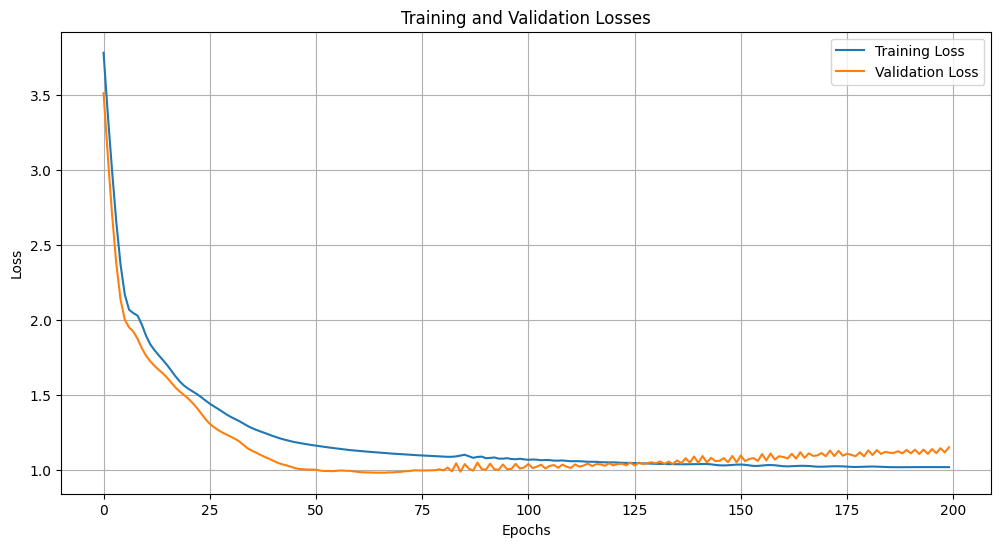

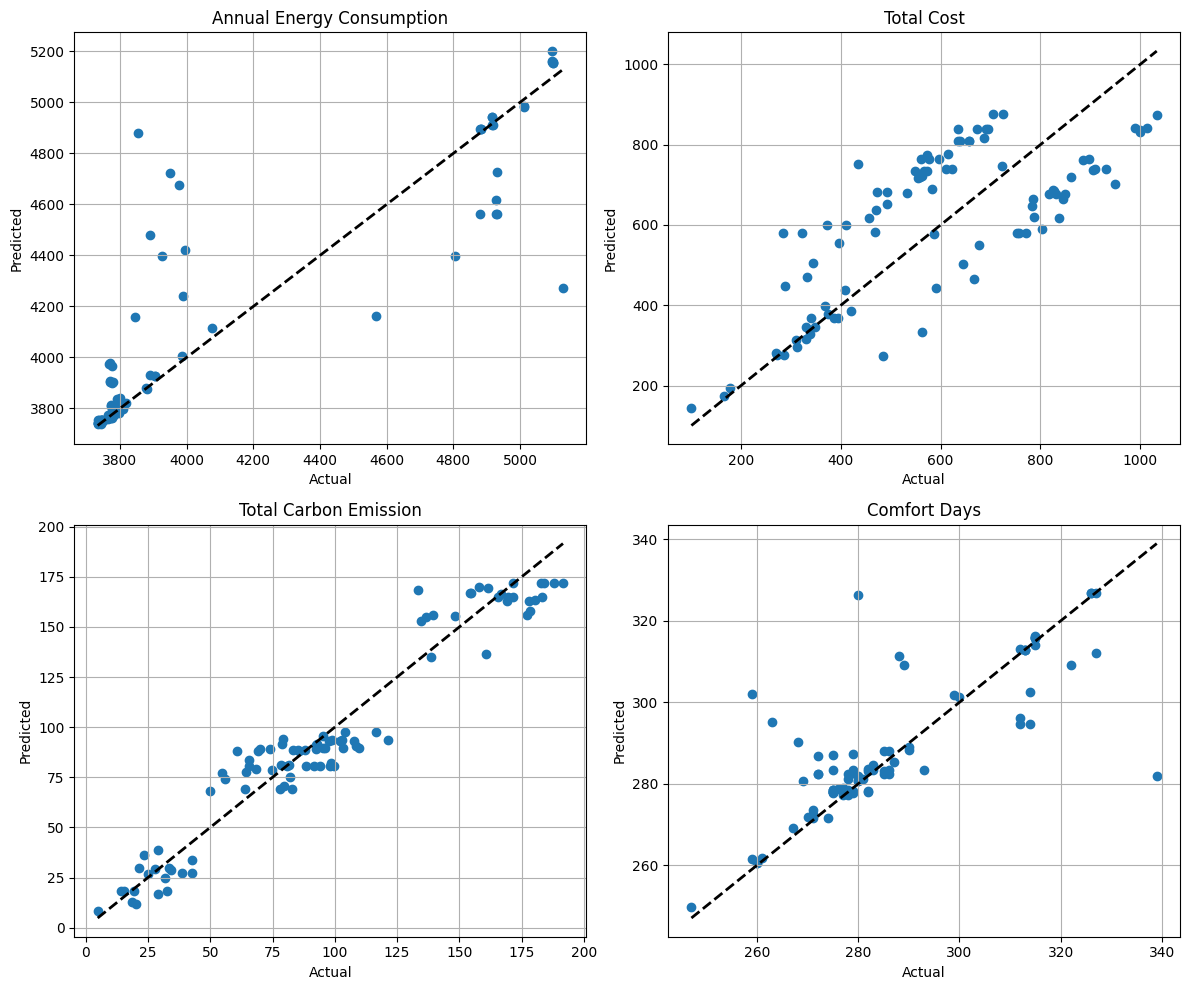

In [ ]:
# Define the Multi-Task Learning Model
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3_energy = nn.Linear(32, 1)  # Annual Energy Consumption
        self.fc3_cost = nn.Linear(32, 1)    # Total Cost
        self.fc3_emission = nn.Linear(32, 1) # Total Carbon Emission
        self.fc3_comfort = nn.Linear(32, 1)  # Comfort Days

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        energy = self.fc3_energy(x)
        cost = self.fc3_cost(x)
        emission = self.fc3_emission(x)
        comfort = self.fc3_comfort(x)
        return energy, cost, emission, comfort

# Instantiate the model, define the loss function and the optimizer
model = MultiTaskModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_inputs)
    loss = sum(criterion(outputs[i], train_outputs[:, i:i+1]) for i in range(4))  # Total loss for all tasks
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs_pred = model(val_inputs)
        val_loss = sum(criterion(val_outputs_pred[i], val_outputs[:, i:i+1]) for i in range(4))
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Testing the model
model.eval()
with torch.no_grad():
    test_outputs_pred = model(test_inputs)

# Inverse transform to get original scale
Y_test_inverse = scaler_Y.inverse_transform(test_outputs.numpy())
Y_test_pred_inverse = scaler_Y.inverse_transform(torch.cat(test_outputs_pred, dim=1).numpy())

# Plotting predicted vs actual outputs
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
outputs_labels = ['Annual Energy Consumption', 'Total Cost', 'Total Carbon Emission', 'Comfort Days']
for i in range(4):
    axs[i // 2, i % 2].scatter(Y_test_inverse[:, i], Y_test_pred_inverse[:, i])
    axs[i // 2, i % 2].plot([Y_test_inverse[:, i].min(), Y_test_inverse[:, i].max()],
                             [Y_test_inverse[:, i].min(), Y_test_inverse[:, i].max()], 'k--', lw=2)
    axs[i // 2, i % 2].set_title(outputs_labels[i])
    axs[i // 2, i % 2].set_xlabel('Actual')
    axs[i // 2, i % 2].set_ylabel('Predicted')
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()